**Transfer learning**


What is transfer learning?

Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

Benefits:
* can leverage an existing neaural network architecture proven to work on problems similar to our own

* Can leverage a working neural network architecture which has already learned patterns on similar data to our own , then we can adapt those patterns to solve similar problem 


**Different types of transfer learning:**
* Using existing model with no change.-**"As is" transfer learning**
* **Feature extraction** : USe pre learned patterns of an existing model (EfficientNetB0 is trained on imagenet and outputs 1000 classes we can use this for our problem by adjusting output layer).
* **Fine tunning transfer learning** - use pre learned patterns of existing model anf fine tune many or all of underline layers.


In [1]:
!nvidia-smi #check do we have GPU runtime environment

Tue Jun  1 08:39:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download data 

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-06-01 08:39:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   176MB/s    in 0.9s    

2021-06-01 08:39:58 (176 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath,dirnames,filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filename)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 10 directori

#### Prepare data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

In [6]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

train_datagen=ImageDataGenerator(rescale=1/255.0)
test_datagen=ImageDataGenerator(rescale=1/255.0)


print("Training images: ")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")


print("Testing images: ")
test_data=test_datagen.flow_from_directory(test_dir,
                                           class_mode="categorical",
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE)

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## setting up callbacks
Extra functionality that you can add to your models to be performed during or after training.
Most popular

* Tracking experiments with the tensorboard callback 
* Model checkpoint with the modelCheckPoint callback
* Early stopping (Stopping model from overfitting)

##### create tensorboard callback

In [7]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to : {log_dir}")
  return tensorboard_callback

#### creating models using tensorflow hub  
It is repository of already `trained models`

https://tfhub.dev


while searching for classification models on tensorflow hub we found below model feature vector:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1



In [8]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense

In [10]:
def create_model(model_url,num_classes=10):
  """
  Takes tensorflow hub url and creates keras sequential model with it

  Args:
      model_url: A tensorflow hub feature extraction url
      num_classes (int): Number of output neurons in the output layer should be eaual to number of target classes 
      default 10
  Returns:
      An uncompiled keras sequential model with model url as feature extracter layer and 
      Dense layer with num of classes output neurons

  """

  #download the pre-trained model and save it as keras layer

  feature_extraction_layer=hub.KerasLayer(model_url,trainable=False,name="Feature_extraction_layer",
                                         input_shape=(224,224,3))
  
  #create our own model
  model=tf.keras.Sequential([
        feature_extraction_layer,
        Dense(num_classes,activation="softmax",name="output_layer")                     
  ])
  return model


In [11]:
#create resnet model
resnet_model=create_model(resnet_url)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 2048)              42626560  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 42,647,050
Trainable params: 20,490
Non-trainable params: 42,626,560
_________________________________________________________________


In [12]:
efficientnet_model=create_model(efficientnet_url)
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In above two models summary we can observe that even if total number of parameters are very high, trainable parameters are very few.This shows the power of using transfer learning, we just need to train last/output layer (dense layer) to get phenomenal results even if we dont have enough data to train.

In [13]:
#now these models are not yet compiled.Let's compile them

resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
tf.random.set_seed(42)
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet50v2")])

Saving tensorboard log files to : tensorflow_hub/resnet50v2/20210601-084022
Epoch 1/5
24/24 [==============================] - 57s 916ms/step - loss: 1.9486 - accuracy: 0.3480 - val_loss: 1.1848 - val_accuracy: 0.6048
Epoch 2/5
24/24 [==============================] - 18s 767ms/step - loss: 0.8716 - accuracy: 0.7307 - val_loss: 0.8511 - val_accuracy: 0.7100
Epoch 3/5
24/24 [==============================] - 18s 764ms/step - loss: 0.5821 - accuracy: 0.8347 - val_loss: 0.7218 - val_accuracy: 0.7680
Epoch 4/5
24/24 [==============================] - 18s 763ms/step - loss: 0.4265 - accuracy: 0.8973 - val_loss: 0.6742 - val_accuracy: 0.7816
Epoch 5/5
24/24 [==============================] - 18s 765ms/step - loss: 0.3335 - accuracy: 0.9413 - val_loss: 0.6433 - val_accuracy: 0.7864


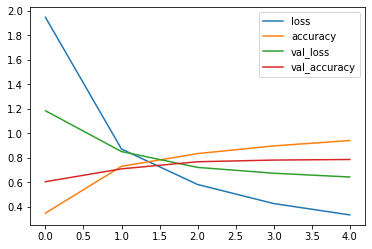

In [15]:
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

In [16]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics

  Args:
      history: Tensorflow history object
  Returns:
      plot of training/validation loss and accuracy metrics      
  """

  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs ,loss ,label="training_loss")
  plt.plot(epochs,val_loss,label="validation_loss")

  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  
  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

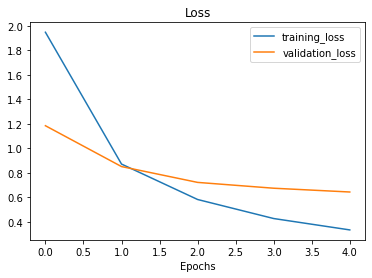

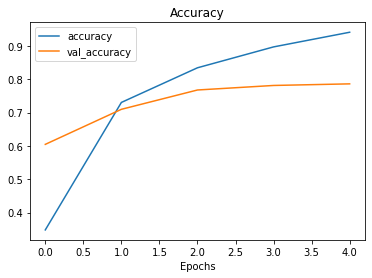

In [17]:
plot_loss_curves(history=resnet_history)

#### Create and test efficientnet feature extractor

In [18]:
tf.random.set_seed(42)
efficientnet_model=create_model("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1")
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
#compile the model
efficientnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

#fit the model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="efficientnet")])

Saving tensorboard log files to : tensorflow_hub/efficientnet/20210601-084240
Epoch 1/5
24/24 [==============================] - 27s 785ms/step - loss: 1.8277 - accuracy: 0.4373 - val_loss: 1.2694 - val_accuracy: 0.7328
Epoch 2/5
24/24 [==============================] - 15s 632ms/step - loss: 1.0596 - accuracy: 0.7600 - val_loss: 0.8563 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 15s 630ms/step - loss: 0.7568 - accuracy: 0.8413 - val_loss: 0.6913 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 15s 637ms/step - loss: 0.6091 - accuracy: 0.8680 - val_loss: 0.6062 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 15s 639ms/step - loss: 0.5141 - accuracy: 0.8960 - val_loss: 0.5511 - val_accuracy: 0.8636


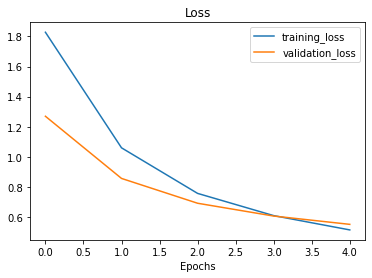

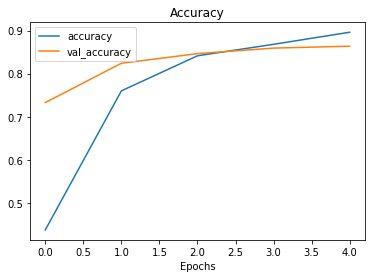

In [20]:
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 12s 148ms/step - loss: 0.5511 - accuracy: 0.8636


[0.5510755181312561, 0.8636000156402588]

#### how to check number of layers in pre-trained model

In [26]:
efficientnet_model.layers

In [27]:
efficientnet_model.layers[0]

In [25]:
len(efficientnet_model.layers[0].weights)

309

#### Compare model results using tensorboard

**Tesnorboard**

A way to visually explore your machine learning models performance and internals.

Host, track and shares your machine learning experiments on Tensorboard.dev(***If data is private do not upload it on here.As uploaded data in this repo will be public***)





In [28]:
#install tensorboard
!pip install tensorboard

In [ ]:
#upload records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientnetB0 vs Resnet50v2" \
 --description "Compare results of two models" \
 --one_shot

###### we can see out experiment results on  https://tensorboard.dev/experiment/37H1hgtMRymwS6VNQ6Z6Rw/

In [31]:
!tensorboard dev list

2021-06-01 09:18:42.709121: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/37H1hgtMRymwS6VNQ6Z6Rw/
	Name                 EfficientnetB0 vs Resnet50v2
	Description          Compare results of two models
	Id                   37H1hgtMRymwS6VNQ6Z6Rw
	Created              2021-06-01 09:08:45 (10 minutes ago)
	Updated              2021-06-01 09:08:48 (9 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  7703821
Total: 1 experiment(s)


In [32]:
#delete record
!tensorboard dev delete --experiment_id 37H1hgtMRymwS6VNQ6Z6Rw

2021-06-01 09:19:42.132536: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment 37H1hgtMRymwS6VNQ6Z6Rw.


In [33]:
#confirm deletion
!tensorboard dev list

2021-06-01 09:20:10.962401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.
